# Estimacion de produccion de Aceite

In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling

font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 20}
plt.rc('font', **font)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams[u'figure.figsize'] = (16,12)
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         }
# plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import sys
sys.path.append('serch_tools/')
import serch_tools as st

from pdpbox import pdp, info_plots
from sklearn.cluster import KMeans
import plotly
import cufflinks

In [531]:
# Modelos
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

# metricas de evaluacion
from sklearn.metrics import (roc_auc_score, classification_report, confusion_matrix,
                            roc_curve, accuracy_score)
# lo mismo pero en grafico
import scikitplot as skplt

# Interpretacion
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import shap

In [532]:
aforos = pd.read_csv("aforos.csv")
analisis_fluidos = pd.read_csv("Analisis_fluidos.csv")
columna_geologica = pd.read_csv('columna_geologica.csv')
eval_petrofisica = pd.read_csv('eval_petrofisica.csv')
intervalo_disparado = pd.read_csv('IntervalosDisparados.csv')
parametros_petrofisicos = pd.read_csv('parametros_petrofisicos.csv')

In [533]:
datos_generales_pozos = pd.read_csv('datos_generales_de_pozos.csv')
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[:6] + datos_generales_pozos[
    'CLASIFICACION_LAHEE'].str[8:]
datos_generales_pozos['CLASIFICACION_LAHEE'] = datos_generales_pozos['CLASIFICACION_LAHEE'].str.replace("/","-")

In [534]:
prod_mens = pd.read_csv('produccion_mensual.csv')
prod_mens.head()

,index,NOMBRE_DEL_POZO,CIMA_INTERVALO_(md),BASE_INTERVALO_(md),CONDICION_DE_FLUJO_(Fluyente/SAP),FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa),RELACION_GAS_LIQUIDO_(m3/m3),RELACION_GAS_ACEITE_(m3/m3),CORTE_DE_AGUA_(bl/bl),SALINIDAD_(PPM),...,RELACION_CONDENSADO_GAS_(m3/m3),RELACION_AGUA_GAS_(m3/m3),RELACION_AGUA_CONDENSADO_(m3/m3),FRACCION_DEL_SEDIMENTO,DIAMETRO_DEL_ESTRANGULADOR _(in),VOLUMEN_DE_ACEITE_(m3),VOLUMEN_DE_GAS_(m3),VOLUMEN_DE_CONDENSADO_(m3),DIAS_DE_PRODUCCION,DESCRIPCION_DE_LA_PRODUCCION
0,0,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/10/2013,101.175571,203.152074,50.205197,SIN INFORMACION,...,NO APLICA,0.004962,NO APLICA,NO APLICA,NO APLICA,31.803914,6462.078342,NO APLICA,31,SIN INFORMACION
1,1,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/11/2013,100.298703,203.279313,50.667656,SIN INFORMACION,...,NO APLICA,0.005052,NO APLICA,NO APLICA,NO APLICA,29.536942,6005.222347,NO APLICA,30,SIN INFORMACION
2,2,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/12/2013,101.159166,203.859067,50.385933,SIN INFORMACION,...,NO APLICA,0.004981,NO APLICA,NO APLICA,NO APLICA,30.852725,6290.627114,NO APLICA,31,SIN INFORMACION
3,3,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/01/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,31.774044,6464.681785,NO APLICA,31,SIN INFORMACION
4,4,MOLOACAN-102A,SIN INFORMACION,SIN INFORMACION,SAP,01/02/2014,101.316590,203.424976,50.202687,SIN INFORMACION,...,NO APLICA,0.004955,NO APLICA,NO APLICA,NO APLICA,28.699137,5839.067419,NO APLICA,28,SIN INFORMACION


In [535]:
prod_mens.columns

Index(['index', 'NOMBRE_DEL_POZO', 'CIMA_INTERVALO_(md)',
       'BASE_INTERVALO_(md)', 'CONDICION_DE_FLUJO_(Fluyente/SAP)',
       'FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)', 'RELACION_GAS_LIQUIDO_(m3/m3)',
       'RELACION_GAS_ACEITE_(m3/m3)', 'CORTE_DE_AGUA_(bl/bl)',
       'SALINIDAD_(PPM)', 'RELACION_AGUA_ACEITE_(m3/m3)',
       'RELACION_CONDENSADO_GAS_(m3/m3)', 'RELACION_AGUA_GAS_(m3/m3)',
       'RELACION_AGUA_CONDENSADO_(m3/m3)', 'FRACCION_DEL_SEDIMENTO',
       'DIAMETRO_DEL_ESTRANGULADOR _(in)', 'VOLUMEN_DE_ACEITE_(m3)',
       'VOLUMEN_DE_GAS_(m3)', 'VOLUMEN_DE_CONDENSADO_(m3)',
       'DIAS_DE_PRODUCCION ', 'DESCRIPCION_DE_LA_PRODUCCION '],
      dtype='object')

In [536]:
prod_mens.groupby(['NOMBRE_DEL_POZO'])['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'].count().median()

121.0

In [537]:
prod_mens['fecha_produccion'] = pd.to_datetime(prod_mens['FECHA_DE_LA_PRODUCCION_(dd/mm/aaaa)'], 
                                               format="%d/%m/%Y")

In [538]:
prod_mens['fecha_produccion'].describe()

count                   20821
unique                    187
top       1999-01-01 00:00:00
freq                      156
first     1999-01-01 00:00:00
last      2014-07-01 00:00:00
Name: fecha_produccion, dtype: object

En algunos posos tenemos un historico de 1999 hasta 2014

# Tabla DB_produccion_Moloacan

Tabla con historico de produccion en unidades de barriles mensuales

    Fecha - Fecha de registro
    Pozo -  Nombre del pozo
    Dias - Numero de dias del mes en curso
    Qo_mes_b - Numero de Barriles de Oil mensuales
    Qo_prom_mesbd - Promedio de barriles diarios Qo_mes_b / Dias
    Qg_mes_MMpc - 
    Qg_prom_mes_MMpcd - Qg_mes_MMpc / Dias
    Qw_mes_b - Numero de barriles de agua mensual
    Qw_prom_mes_bd - Promedio de barriles mensuales de agua  Qw_mes_b / Dias
    Fw_% - Porcentaje de Agua
    RGA_m3/m3 - Relacion Gas Aceite
    Dias_de_Operacion - Dias que estuvo operando la plataforma

In [539]:
db_prod_mol = pd.read_csv('DB_prod_moloacan.csv')
db_prod_mol.columns = db_prod_mol.columns.str.replace(" ","_").str.replace(
    "(","").str.replace(")","").str.replace(".","").str.replace('á',"a").str.replace('é',"e").str.replace(
    'í',"i").str.replace('ó',"o").str.replace('ú',"u")
# transfromaciones
db_prod_mol['Qo_mes_b'] = db_prod_mol['Qo_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['Qw_mes_b'] = db_prod_mol['Qw_mes_b'].str.replace(',', '').astype(float)
db_prod_mol['RGA_m3/m3'] = db_prod_mol['RGA_m3/m3'].str.replace(',', '').astype(float)
db_prod_mol["Pozo"] = db_prod_mol.Pozo.str.replace("Á","A")

In [540]:
db_prod_mol.columns

Index(['Fecha', 'Pozo', 'Dias', 'Qo_mes_b', 'Qo_prom_mesbd', 'Qg_mes_MMpc',
       'Qg_prom_mes_MMpcd', 'Qw_mes_b', 'Qw_prom_mes_bd', 'Fw_%', 'RGA_m3/m3',
       'Dias_de_Operacion'],
      dtype='object')

In [541]:
db_prod_mol['fecha_produccion'] = pd.to_datetime(db_prod_mol.Fecha, format="%d/%m/%Y")

In [542]:
db_prod_mol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20886 entries, 0 to 20885
Data columns (total 13 columns):
Fecha                20886 non-null object
Pozo                 20886 non-null object
Dias                 20886 non-null int64
Qo_mes_b             20886 non-null float64
Qo_prom_mesbd        20886 non-null float64
Qg_mes_MMpc          20886 non-null float64
Qg_prom_mes_MMpcd    20886 non-null float64
Qw_mes_b             20886 non-null float64
Qw_prom_mes_bd       20886 non-null float64
Fw_%                 20886 non-null float64
RGA_m3/m3            20886 non-null float64
Dias_de_Operacion    20886 non-null int64
fecha_produccion     20886 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2), object(2)
memory usage: 2.1+ MB


# Se estimara el numero de barriles mensuales

Se generan variables que expliquen la produccion en $P(t)$ con un historico de 6 meses con variables como $P(t-1), P(t-2), P(t-3)$

Se estima
$P(t) = \alpha + \beta_1 P(t-1)+ \beta_1 P(t-2)+ \beta_1 P(t-3)+ \beta_1 P(t-4)+ \beta_1 P(t-5)+ \beta_1 P(t-6) + \epsilon$

In [543]:
# tabla (t-6)
t = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first()

# tabla (t - 5)
t_1 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-1)

# tabla (t -4)
t_2 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-2)

# tabla (t - 3)
t_3 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-3)

# tabla (t - 2)
t_4 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-4)

# tabla (t -1)
t_5 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-5)

# tabla (t) variable a estimar
t_6 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-6)

# tabla (t + 1) se genera para quitar picos abajo o rellenarlo con media movil
t_7 = db_prod_mol.groupby(['Pozo','fecha_produccion']).Qo_mes_b.first().shift(-7)

Variables de produccion anterior, pensando que produciran semejante al mes anterior

In [544]:
df = pd.concat([t,t_1,t_2,t_3,t_4,t_5,t_6],1).dropna()
df.columns = ['Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t']

In [545]:
df = pd.concat([df,t_7],1)
df.columns = ['Produccion_barriles_t_6','Produccion_barriles_t_5','Produccion_barriles_t_4',
              'Produccion_barriles_t_3','Produccion_barriles_t_2','Produccion_barriles_t_1',
              'Produccion_barriles_t','Produccion_barriles_t_mas_1']

In [546]:
df.shape # numero de registros

(20886, 8)

In [548]:
df['diff_t_6_t_5'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_5
df['diff_t_5_t_4'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_4
df['diff_t_4_t_3'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_3
df['diff_t_3_t_2'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_2
df['diff_t_2_t_1'] = df.Produccion_barriles_t_2 - df.Produccion_barriles_t_1

df['diff_t_6_t_1'] = df.Produccion_barriles_t_6 - df.Produccion_barriles_t_1
df['diff_t_5_t_1'] = df.Produccion_barriles_t_5 - df.Produccion_barriles_t_1
df['diff_t_4_t_1'] = df.Produccion_barriles_t_4 - df.Produccion_barriles_t_1
df['diff_t_3_t_1'] = df.Produccion_barriles_t_3 - df.Produccion_barriles_t_1

df['aceleracion_de_produccion _t3t2_t2t1'] = df['diff_t_3_t_2'] - df['diff_t_2_t_1']
df['aceleracion_de_produccion _t4t3_t2t1'] = df['diff_t_4_t_3'] - df['diff_t_2_t_1']

In [549]:
df.columns

Index(['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1',
       'Produccion_barriles_t', 'Produccion_barriles_t_mas_1', 'diff_t_6_t_5',
       'diff_t_5_t_4', 'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1',
       'diff_t_6_t_1', 'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1'],
      dtype='object')

Variables de diferencia entre periodos, como una velocidad de produccion entre un mes y otro.

In [550]:
# desviacion estandar
df['std_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].std(1)
# mediana
df['median_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].median(1)
# minimo
df['min_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].min(1)
#quantiles
df['q75_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.75,axis=1)
df['q25_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.25,axis=1)
df['q90_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.90,axis=1)
df['q10_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].quantile(0.10,axis=1)
#maximo
df['max_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
       'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
       'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].max(1)

#rango
df['rango_t6_t1'] = df['max_t_6_t_1'] - df['min_t_6_t_1']

Variables estadisticas sobre el historico de 6 meses.
+ std si varia mucho puede que ayude a predecir la produccion
+ median, mean es probable que produzca al menos el promedio que ha producido antes
+ min Si ya paso por un bache de produccion puede indicarnos si seguira ahi... NO ESTOY SEGURO
+ max Si esta en un pico de produccion o ya lo paso, al menos no va a sobrepasar este valor
+  rango Acota la produccion esperada para no sobreestimar
+ quantiles en 6 meses

In [551]:
# medias moviles
df['media_movil_t_2_t_1'] = df[['Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_3_t_1'] = df[[ 'Produccion_barriles_t_3',
                                'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_4_t_1'] = df[['Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)
df['media_movil_t_5_t_1'] = df[['Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

df['media_movil_t_6_t_1'] = df[['Produccion_barriles_t_6', 'Produccion_barriles_t_5',
                               'Produccion_barriles_t_4', 'Produccion_barriles_t_3',
                               'Produccion_barriles_t_2', 'Produccion_barriles_t_1']].mean(1)

Se crean variables de medias moviles

In [ ]:
[['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1','std_t_6_t_1']]

In [552]:
df['dummi_pico_bajo'] = np.where(df.media_movil_t_6_t_1 - 5*df.std_t_6_t_1 > df.Produccion_barriles_t,1,0)

In [553]:
df[df.dummi_pico_bajo==1][['Produccion_barriles_t_1','Produccion_barriles_t','Produccion_barriles_t_mas_1',
                           'std_t_6_t_1','media_movil_t_6_t_1']].head()

Produccion_barriles_t_1  \
Pozo          fecha_produccion                            
MOLOACAN-1004 2004-08-01                         194.98   
MOLOACAN-102D 1999-06-01                         278.20   
              2001-08-01                         353.60   
              2002-03-01                         343.05   
              2006-03-01                         210.84   

                                Produccion_barriles_t  \
Pozo          fecha_produccion                          
MOLOACAN-1004 2004-08-01                       157.25   
MOLOACAN-102D 1999-06-01                       137.72   
              2001-08-01                       295.96   
              2002-03-01                       100.67   
              2006-03-01                       180.66   

                                Produccion_barriles_t_mas_1  std_t_6_t_1  \
Pozo          fecha_produccion                                             
MOLOACAN-1004 2004-08-01                             147.68     5.215265   
MOLOACAN-102D 1999-06-01                             158.48    19.174908   
              2001-08-01                             365.47     9.395236   
              2002-03-01                             171.54    16.882444   
              2006-03-01                             196.87     3.918645   

                                media_movil_t_6_t_1  
Pozo          fecha_produccion                       
MOLOACAN-1004 2004-08-01                 190.136667  
MOLOACAN-102D 1999-06-01                 289.156667  
              2001-08-01                 343.876667  
              2002-03-01                 346.775000  
              2006-03-01                 210.891667

In [554]:
df[df.dummi_pico_bajo==1].shape

(856, 34)

In [555]:
df = df[df.dummi_pico_bajo!=1]

In [556]:
db_prod_mol['f_prod'] = db_prod_mol.fecha_produccion

dummie de mes

In [557]:
# tabla dummies_month
dummi_month = pd.get_dummies(db_prod_mol.groupby(
    ['Pozo','fecha_produccion']).f_prod.first().shift(-6).dt.month.dropna().astype(int).dropna(),prefix='month')
dummi_month.head()

month_1  month_2  month_3  month_4  month_5  \
Pozo          fecha_produccion                                                
MOLOACAN-1004 2002-06-01              1        0        0        0        0   
              2002-07-01              0        1        0        0        0   
              2002-08-01              0        0        1        0        0   
              2002-09-01              0        0        0        1        0   
              2002-10-01              0        0        0        0        1   

                                month_6  month_7  month_8  month_9  month_10  \
Pozo          fecha_produccion                                                 
MOLOACAN-1004 2002-06-01              0        0        0        0         0   
              2002-07-01              0        0        0        0         0   
              2002-08-01              0        0        0        0         0   
              2002-09-01              0        0        0        0         0   
              2002-10-01              0        0        0        0         0   

                                month_11  month_12  
Pozo          fecha_produccion                      
MOLOACAN-1004 2002-06-01               0         0  
              2002-07-01               0         0  
              2002-08-01               0         0  
              2002-09-01               0         0  
              2002-10-01               0         0

In [558]:
df = pd.merge(df, dummi_month, right_index=True, left_index=True)

## Si estuvo detenido

In [559]:
# detenido_mes_anterior = pd.DataFrame(np.where(((db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-6) - db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().shift(-5))/np.timedelta64(1,"D")) < 31, 1, 0), index=db_prod_mol.groupby(
#     ['Pozo','fecha_produccion']).f_prod.first().index, columns=['detenido_mes_antes'])
# detenido_mes_anterior.head()

In [560]:
# df = pd.merge(df, detenido_mes_anterior, right_index=True, left_index=True)

# Latitud y longitud

In [561]:
lat_lon_pozo = datos_generales_pozos.groupby('NOMBRE_DE_POZO')[['LATITUD','LONGITUD']].first()
lat_lon_pozo.reset_index(inplace=True)
lat_lon_pozo.columns = ['Pozo','latitud', 'longitud']
lat_lon_pozo.head()

,Pozo,latitud,longitud
0,MOLOACAN-1,17.987072,-94.381714
1,MOLOACAN-101,17.982659,-94.369994
2,MOLOACAN-102,17.982043,-94.367304
3,MOLOACAN-102A,17.982088,-94.367397
4,MOLOACAN-11,17.986597,-94.373105


In [562]:
df_train = df.reset_index().merge(lat_lon_pozo, how='left',on='Pozo').dropna()

In [563]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,latitud,longitud
214,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,186.59,...,0,0,1,0,0,0,0,0,17.985929,-94.370707
215,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,197.52,...,0,0,0,1,0,0,0,0,17.985929,-94.370707
216,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,215.72,...,0,0,0,0,1,0,0,0,17.985929,-94.370707
217,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,185.47,...,0,0,0,0,0,1,0,0,17.985929,-94.370707
218,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,137.72,...,0,0,0,0,0,0,1,0,17.985929,-94.370707


In [564]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1',
       'aceleracion_de_produccion _t4t3_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'latitud', 'longit

# Variable de tecnologia
Se le pega el nombre del equipo de perforacion para saber si es mejor o peor para la produccion

In [565]:
# pegar a pozo nombre_equipo_perfo
nombre_equi_perfo = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['NOMBRE_EQUIPO_DE_PERFORACION'].first())
nombre_equi_perfo.reset_index(inplace=True)
nombre_equi_perfo.columns = ['Pozo','equipo_perforacion']
# se encontraron inconsistencias en la info
nombre_equi_perfo["equipo_perforacion"] = nombre_equi_perfo.equipo_perforacion.str.replace(
    "PM5597-","PM-5597").str.replace(
    "PM.-5597","PM-5597").str.replace(
    "PM.5599","PM-5599")
nombre_equi_perfo.head()

,Pozo,equipo_perforacion
0,MOLOACAN-1,SIN INFORMACION
1,MOLOACAN-101,SIN INFORMACION
2,MOLOACAN-102,SIN INFORMACION
3,MOLOACAN-102A,PM-5597
4,MOLOACAN-11,PM-111


In [566]:
df_train = df_train.merge(nombre_equi_perfo, how='left',on='Pozo').dropna()

In [567]:
df_train = pd.get_dummies(df_train, columns=['equipo_perforacion'])

In [568]:
df_train.shape

(19629, 64)

# variable clasificaccion LAHEE
La Clasificación Lahee, los pozos pueden ser identificados como:
+ Pozo Exploratorio
+ Pozos Productores
+ Pozos no Productores (Secos)
+ Pozos de Desarrollo
+ Pozo de Avanzada

Codigos

    07-07-01 - Pozo de desarrollo, productor aceite
    07-07-06 - Pozo de desarrollo, improductivo, invadido de agua salada
    07-07-13 - 07 Pozo de desarrollo
    07-07-04 - Pozo de desarrollo, productor incosteable
    07-07-07 - Pozo de desarrollo, improductivo seco
    04-04-01 - Pozo en busca de nueva acumulacion en campo ya productor, productor de aceite
    07-01-00 - 07 Pozo de desarrollo
    04-04-06 - Pozo en busca de nueva acumulacion en campo ya productor, improductivo, invadido de agua salada
    01-01-06 - Pozo en busca de nueva acumulacion, improductivo, invadido de agua salada
    SIN INFORMACION

Referencia de codigos https://bndh.gob.do/wp-content/uploads/2016/04/4.3-MEM-BNDH-RD-Tercer-Informe-de-Avances_v2-1.pdf

In [569]:
clasifi_lahee = pd.DataFrame(datos_generales_pozos.groupby(
    'NOMBRE_DE_POZO')['CLASIFICACION_LAHEE'].first())
clasifi_lahee.reset_index(inplace=True)
clasifi_lahee.columns = ['Pozo','clasificacion_lahee']
clasifi_lahee.head()

,Pozo,clasificacion_lahee
0,MOLOACAN-1,07-07-01
1,MOLOACAN-101,07-07-07
2,MOLOACAN-102,07-07-06
3,MOLOACAN-102A,07-07-01
4,MOLOACAN-11,07-07-01


In [439]:
df_train = df_train.merge(clasifi_lahee, how='left',on='Pozo').dropna()

In [440]:
df_train = pd.get_dummies(df_train, columns=['clasificacion_lahee'])

In [441]:
df_train.shape

(20171, 66)

In [442]:
df_train.head()

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_PM-5599,equipo_perforacion_PM-5620,equipo_perforacion_PM-5626,equipo_perforacion_PM-5627,equipo_perforacion_PM-73,equipo_perforacion_PM-78,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION
0,MOLOACAN-111,1999-01-01,169.92,159.46,193.95,169.10,182.03,177.28,191.66,186.59,...,0,0,0,0,0,0,0,1,1,0
1,MOLOACAN-111,1999-02-01,159.46,193.95,169.10,182.03,177.28,191.66,186.59,197.52,...,0,0,0,0,0,0,0,1,1,0
2,MOLOACAN-111,1999-03-01,193.95,169.10,182.03,177.28,191.66,186.59,197.52,215.72,...,0,0,0,0,0,0,0,1,1,0
3,MOLOACAN-111,1999-04-01,169.10,182.03,177.28,191.66,186.59,197.52,215.72,185.47,...,0,0,0,0,0,0,0,1,1,0
4,MOLOACAN-111,1999-05-01,182.03,177.28,191.66,186.59,197.52,215.72,185.47,137.72,...,0,0,0,0,0,0,0,1,1,0


# pendiente pico historico

In [443]:
# df_d_prod = db_prod_mol.groupby(['Pozo','fecha_produccion']).f_prod.first().shift(-6).reset_index()
# db_prod_mol['fecha_y'] = df_d_prod.f_prod

In [444]:
# for i in db_prod_mol.groupby('Pozo')[['Qo_mes_b','fecha_produccion','fecha_y']]:
#     print(i[0])
#     print(i[1][i[1].fecha_produccion >= i[1].fecha_y])

In [445]:
# y_temp = []
# for i in sample_prod_data.groupby('API')['Liquid']:
# #     print(i[0])
# #     print(i[1][i[1].index >= idx_prod_max_api[i[0]]].sum())
#     y_temp.append([i[0], i[1][i[1].index >= idx_prod_max_api[i[0]]].sum()])

In [446]:
# idx_prod_max_api = prod_data_train.groupby('API').Liquid.idxmax()

In [447]:
# # AQUI SE CREA LA Y (se puede hacer lista de comprension)
# pico_temp = []
# for i in db_prod_mol.groupby('Pozo')['Qo_mes_b']:
#     pico_temp.append([i[0], i[1][i[1].fecha_produccion >= idx_prod_max_api[i[0]]].sum()])

In [448]:
# db_prod_mol.columns

In [449]:
# db_prod_mol.groupby('Pozo')[['fecha_produccion','f_prod']].last()

In [450]:
# db_prod_mol.groupby(
#     ['Pozo','fecha_produccion'])

In [451]:
df_train.shape

(20171, 66)

## Quitamos Outliers

In [453]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'latitud', 'longitud', 'equipo_perfo

In [454]:
df_train = df_train[df_train.Produccion_barriles_t > df_train.Produccion_barriles_t.quantile(0.005)]
df_train = df_train[df_train.Produccion_barriles_t_1 > df_train.Produccion_barriles_t_1.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_2 > df_train.Produccion_barriles_t_2.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_3 > df_train.Produccion_barriles_t_3.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_4 > df_train.Produccion_barriles_t_4.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_5 > df_train.Produccion_barriles_t_5.quantile(0.001)]
df_train = df_train[df_train.Produccion_barriles_t_6 > df_train.Produccion_barriles_t_6.quantile(0.001)]

In [455]:
df_train = df_train[df_train.Produccion_barriles_t < df_train.Produccion_barriles_t.quantile(0.99)]

In [456]:
df_train = df_train[df_train.Produccion_barriles_t_1 < df_train.Produccion_barriles_t_1.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_2 < df_train.Produccion_barriles_t_2.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_3 < df_train.Produccion_barriles_t_3.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_4 < df_train.Produccion_barriles_t_4.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_5 < df_train.Produccion_barriles_t_5.quantile(0.99)]
df_train = df_train[df_train.Produccion_barriles_t_6 < df_train.Produccion_barriles_t_6.quantile(0.99)]

In [457]:
df_train.reset_index(inplace=True, drop=True)

In [458]:
df_train.shape

(18538, 66)

# Clustering Vemos que hay tipos de pozos con produccion similar

In [459]:
from sklearn.cluster import KMeans

In [460]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'latitud', 'longitud', 'equipo_perfo

In [461]:
num_cols = ['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1',
        
        'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
            
       'aceleracion_de_produccion _t3t2_t2t1', 
            'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 
            'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1',
         'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 
            'detenido_mes_antes',
       'latitud', 'longitud', 
            'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION', 
            'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION']

In [462]:
df_std = (df_train[num_cols] - df_train[num_cols].mean()) / df_train[num_cols].std()

In [463]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_std)
    Sum_of_squared_distances.append(km.inertia_)

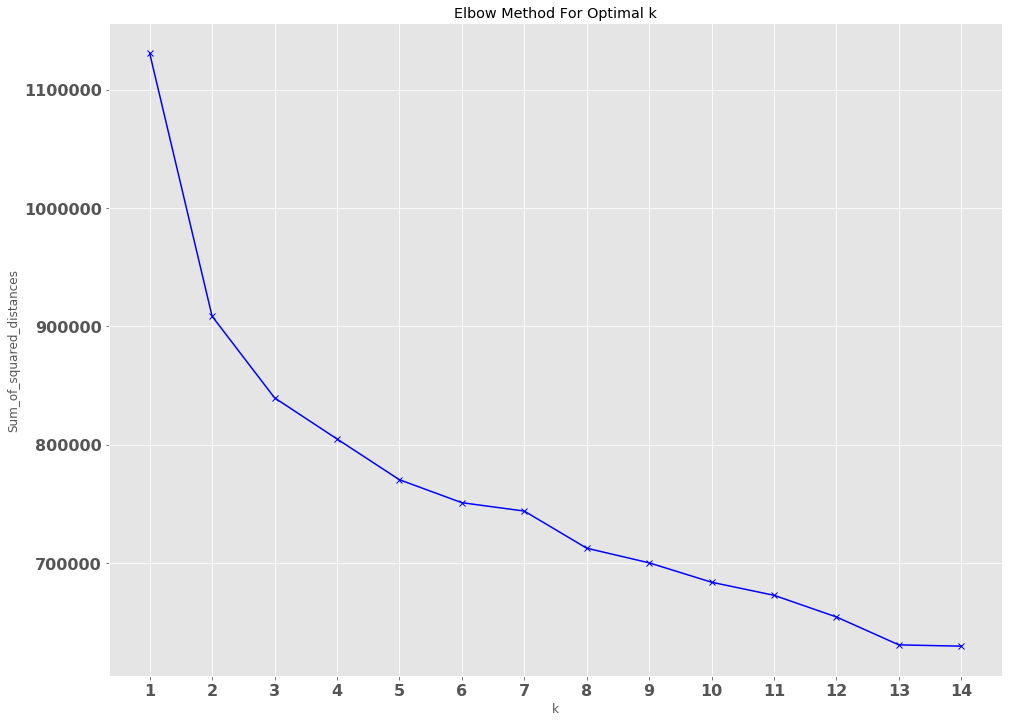

In [464]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(np.arange(1,15));

In [465]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [466]:
df_train = pd.concat([df_train,pd.get_dummies(kmeans.predict(df_std),prefix="cluster")],1).dropna()

In [467]:
df_train["cluster"] = kmeans.predict(df_std)

Si ayuda agregar clusters, vemos que hay pozos que producen menos.

# Caracteristicas del pozo

In [468]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'latitud', 'longitud', 'equipo_perfo

# AED

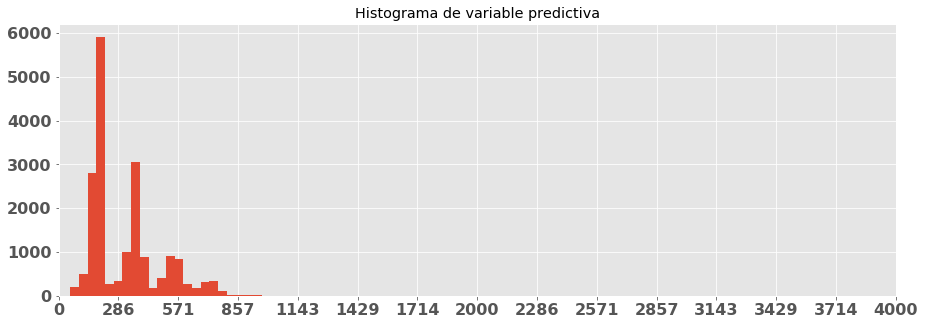

In [470]:
df_train.Produccion_barriles_t.hist(bins=25, figsize=(15,5))
plt.title('Histograma de variable predictiva')
plt.xticks(np.linspace(0,4000,15));

# Dispersiones

In [471]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'latitud', 'longitud', 'equipo_perfo

In [472]:
num_cols = ['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 
            'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 
            'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 
            'detenido_mes_antes',
       'latitud', 'longitud',
            'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION', 'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION', 
            'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster']

En algun momento dibujaras un mapa aqui

In [473]:
lat = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
lon = df_train.groupby('Pozo')[['latitud','longitud']].first().latitud.values
idx = df_train.groupby('Pozo')[['latitud','longitud']].first().index.values

In [474]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'latitud', 'longitud', 'equipo_perfo

Text(0.5, 1.0, 'Observamos que hay pozos estables en cantidad de produccion y\n            otros que ascienden o descienden en produccion')

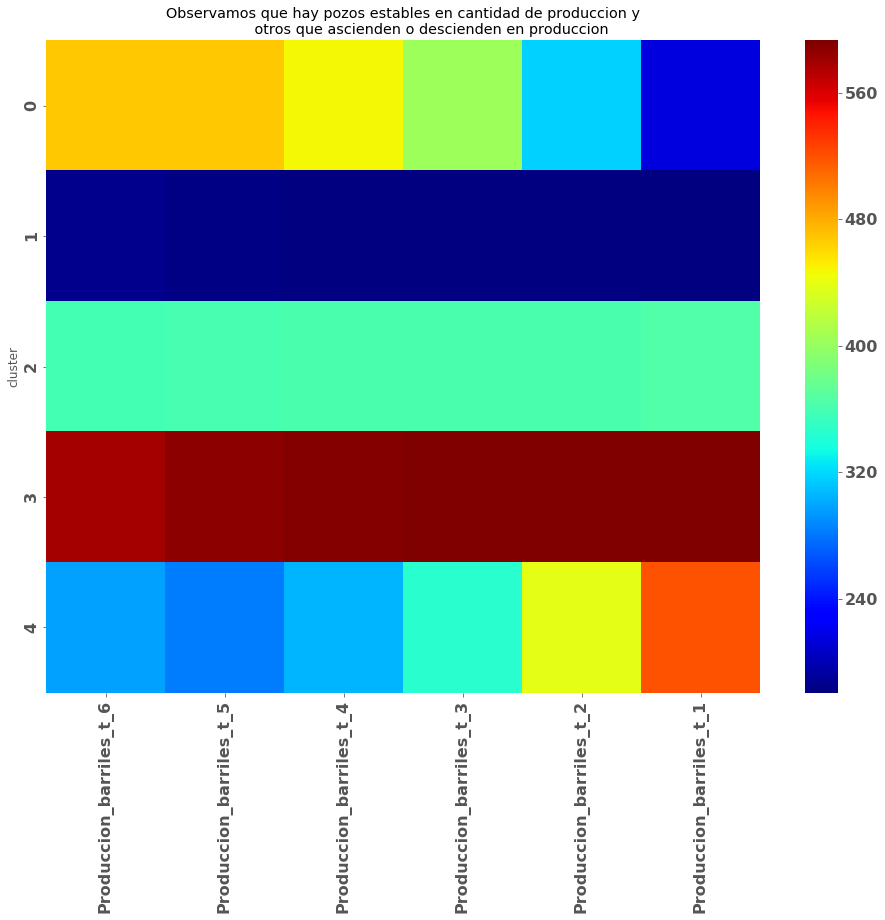

In [478]:
sns.heatmap(df_train.groupby('cluster')[[ 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1']].mean(),cmap='jet')
plt.title('''Observamos que hay pozos estables en cantidad de produccion y
            otros que ascienden o descienden en produccion''')

# Entrenamiento

In [479]:
df_train.columns

Index(['Pozo', 'fecha_produccion', 'Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 'Produccion_barriles_t',
       'Produccion_barriles_t_mas_1', 'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
       'aceleracion_de_produccion _t3t2_t2t1', 'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 'dummi_pico_bajo', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'detenido_mes_antes',
       'latitud', 'longitud', 'equipo_perfo

In [480]:
num_cols =['Produccion_barriles_t_6',
       'Produccion_barriles_t_5', 'Produccion_barriles_t_4',
       'Produccion_barriles_t_3', 'Produccion_barriles_t_2',
       'Produccion_barriles_t_1', 
           'diff_t_6_t_5', 'diff_t_5_t_4',
       'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'diff_t_6_t_1',
       'diff_t_5_t_1', 'diff_t_4_t_1', 'diff_t_3_t_1',
           
       'aceleracion_de_produccion _t3t2_t2t1',
           'std_t_6_t_1', 'median_t_6_t_1',
       'min_t_6_t_1', 'q75_t_6_t_1', 'q25_t_6_t_1', 'q90_t_6_t_1',
       'q10_t_6_t_1', 'max_t_6_t_1', 'rango_t6_t1', 
           'media_movil_t_2_t_1',
       'media_movil_t_3_t_1', 'media_movil_t_4_t_1', 'media_movil_t_5_t_1',
       'media_movil_t_6_t_1', 
            'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12',
           'detenido_mes_antes',
       'latitud', 'longitud',
           'equipo_perforacion_PM-113',
       'equipo_perforacion_PM-472', 'equipo_perforacion_PM-504',
       'equipo_perforacion_PM-5571', 'equipo_perforacion_PM-5596',
       'equipo_perforacion_PM-5597', 'equipo_perforacion_PM-5599',
       'equipo_perforacion_PM-5620', 'equipo_perforacion_PM-5626',
       'equipo_perforacion_PM-5627', 'equipo_perforacion_PM-73',
       'equipo_perforacion_PM-78', 'equipo_perforacion_PM-92',
       'equipo_perforacion_SIN INFORMACION',
           'clasificacion_lahee_07-07-01',
       'clasificacion_lahee_SIN INRMACION', 
           'cluster_0', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4']

In [481]:
x_train, x_test, x_valid, y_train, y_test, y_valid = st.train_test_valid_split(df_train, num_cols, 'Produccion_barriles_t')

In [482]:
x_train.shape

(13347, 66)

In [483]:
d_train = lgb.Dataset(x_train, y_train)
d_test = lgb.Dataset(x_test, label=y_test)

params = {}
params['learning_rate'] = 0.001
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'
params['sub_feature'] = 0.8
params['num_leaves'] = 25
params['min_data'] = 10
params['max_depth'] = -1
params['num_iterations'] = 100000

clf = lgb.train(params, d_train, 100, valid_sets=[d_test], early_stopping_rounds=25,verbose_eval=10000)

Training until validation scores don't improve for 25 rounds.
Early stopping, best iteration is:
[7539]	valid_0's l1: 24.3627


In [484]:
clf.num_trees()

7539

# Optimizacion de Hiperparametros

In [ ]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
#gs.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
clf_sw = lgb.LGBMClassifier(**clf.get_params())
#set optimal parameters
clf_sw.set_params(**opt_parameters)

In [ ]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, 
                                param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc',
                                cv=5,
                                refit=True,
                                verbose=True)

In [ ]:
gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

# Evaluacion

In [485]:
y_pred = clf.predict(x_valid)

In [501]:
from sklearn import metrics
def report_evaluation_regression(y_real, y_pred, num_features):
    """Reporte de evaluacion,
    y_real, y_pred=y_estimada,num_features=numero de variables"""
    R2=metrics.r2_score(y_real,y_pred)
    n=len(y_real)
    p=num_features
    r2 = 1-(1-R2)*(n-1)/(n-p-1)
    
    
    print("$R^2$: %1.4f" % R2)
    
    print("$R^2$ ajustada$: %1.4f" % r2)
    
    print("MEA: %1.4f" % metrics.mean_absolute_error(y_real,y_pred))
    print("MSE %1.4f" % metrics.mean_squared_error(y_real,y_pred))
    print("RMSE %1.4f" % np.sqrt(metrics.mean_squared_error(y_real,y_pred)))
    

In [502]:
report_evaluation_regression(y_valid, y_pred, x_train.shape[1])

$R^2$: 0.9039
$R^2$ ajustada$: 0.9003
MEA: 23.3859
MSE 2782.8139
RMSE 52.7524


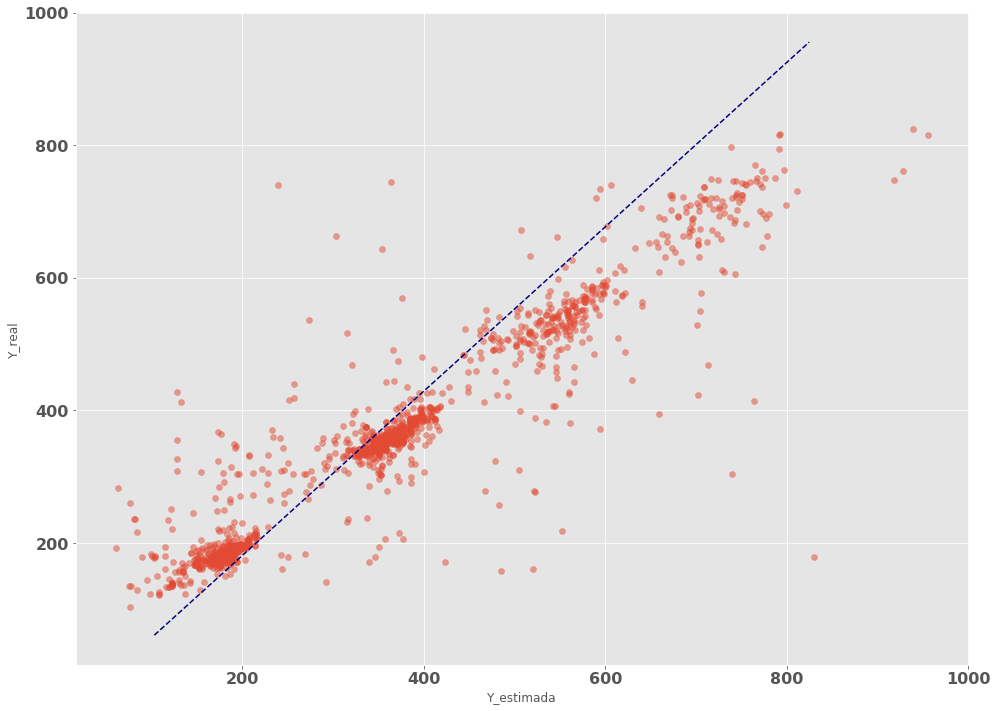

In [488]:
st.yy_plot(y_valid, y_pred)

## Residuos

In [489]:
res = (y_valid - y_pred) / y_valid

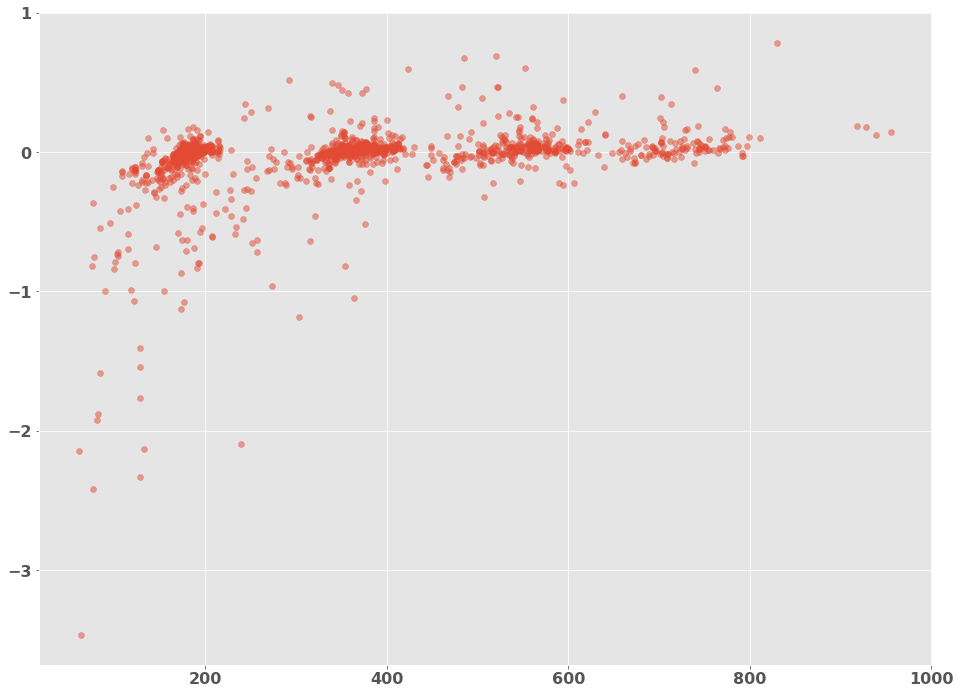

In [490]:
plt.scatter(y_valid, res, alpha=0.5)

In [491]:
res.median() * 100

0.3941851791159242

In [492]:
res.mean() * 100

-2.8576586409372995

In [493]:
df_train.loc[res[res<-5].index]

,Pozo,fecha_produccion,Produccion_barriles_t_6,Produccion_barriles_t_5,Produccion_barriles_t_4,Produccion_barriles_t_3,Produccion_barriles_t_2,Produccion_barriles_t_1,Produccion_barriles_t,Produccion_barriles_t_mas_1,...,equipo_perforacion_PM-92,equipo_perforacion_SIN INFORMACION,clasificacion_lahee_07-07-01,clasificacion_lahee_SIN INRMACION,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster


In [494]:
res[res<-5]

Series([], Name: Produccion_barriles_t, dtype: float64)

## Autocorrelacion

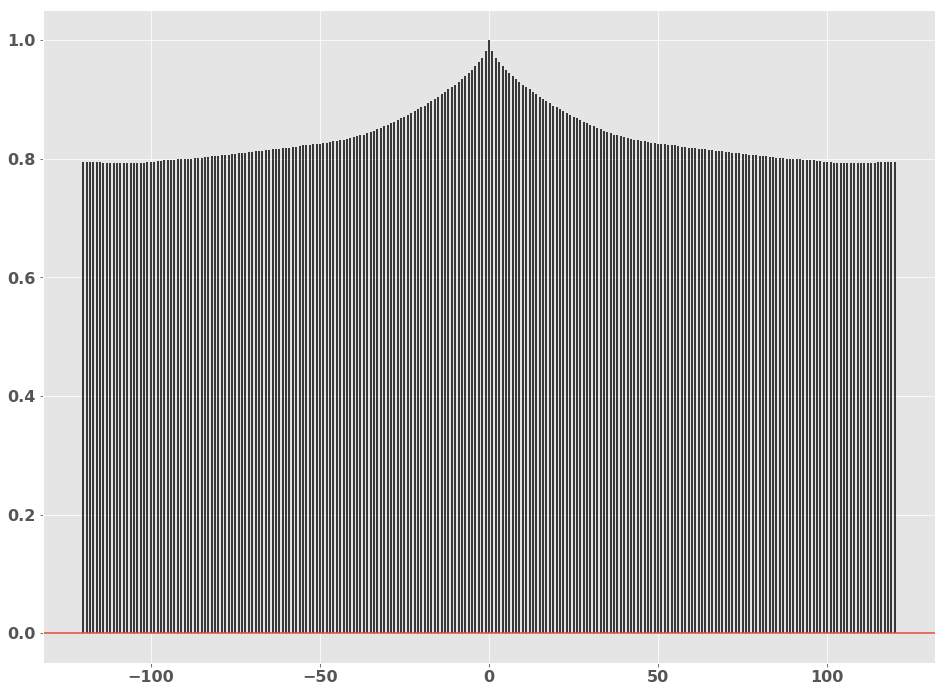

In [529]:
plt.xcorr(df_train.Produccion_barriles_t, df_train.Produccion_barriles_t,maxlags=120, usevlines=1)
plt.show()

Blogs indican que es mejor hacer la estimacion de $\hat{y}=P(t)-P(t-1)=\alpha + \sum {\beta X_i} + \epsilon$

Se generan mas variables para ayudarle al modelo

# Interpretacion

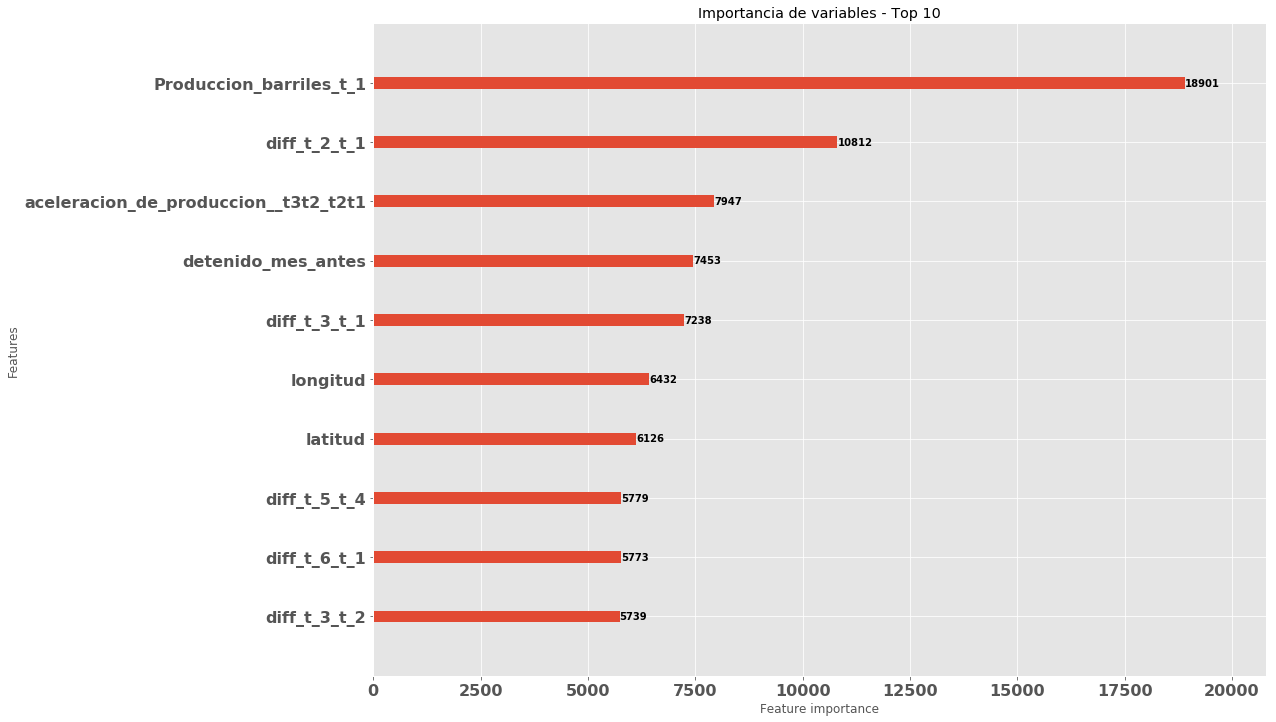

In [503]:
lgb.plot_importance(clf,max_num_features=10, title='Importancia de variables - Top 10')

In [504]:
explainer, shap_values = st.shap_shap(clf, x_valid)

In [505]:
shap.force_plot(explainer.expected_value, shap_values[5,:], x_valid.iloc[5,:])

## Efectos Marginales

In [335]:
a = pd.DataFrame(clf.feature_importance(), index=x_valid.columns,
             columns=['imp']).sort_values('imp')

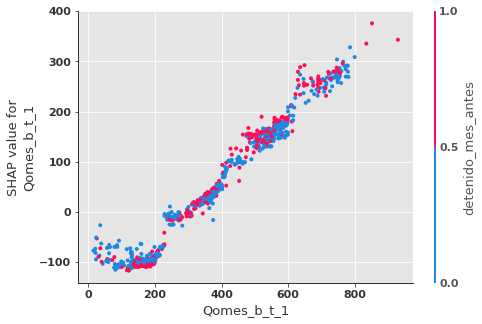

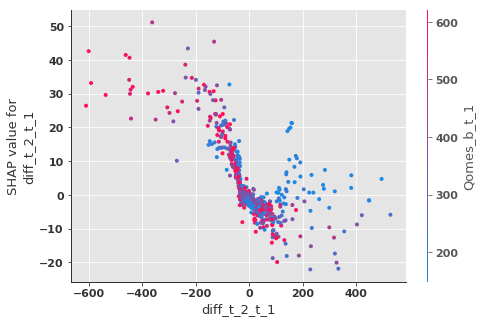

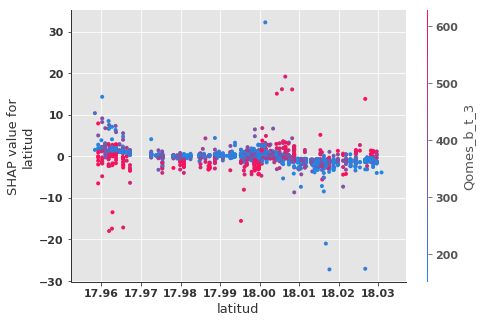

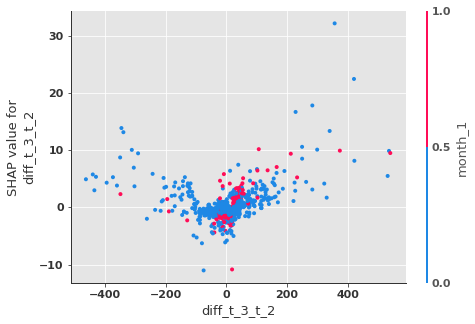

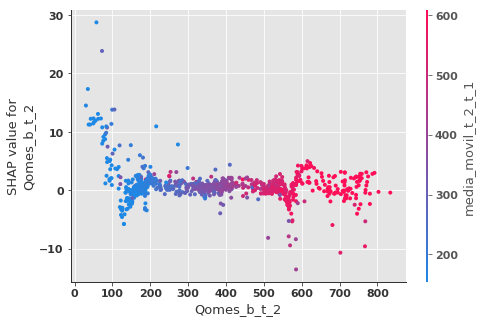

In [336]:
for col in a.sort_values('imp',ascending=False).head(5).index:
    shap.dependence_plot(col, shap_values, x_valid)

# Check de pozos aleatorios

In [508]:
idx = df_train.Pozo.sample(10)

In [509]:
index = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().index

In [510]:
validacion = df_train[df_train.Pozo.isin(idx)].groupby(['Pozo','fecha_produccion']).Produccion_barriles_t.first().unstack(0)

In [511]:
prediction = clf.predict(df_train[df_train.Pozo.isin(idx)][num_cols])

In [512]:
prediccion_validacion = pd.DataFrame(prediction,columns=['prediction']).set_index(index).unstack(0)

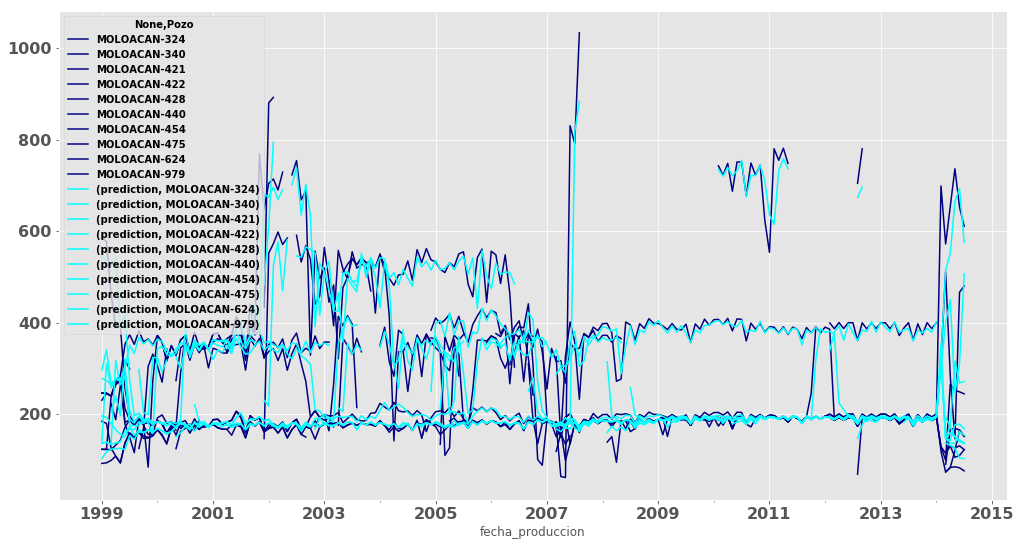

In [513]:
ax = validacion.plot(figsize=(17,9),color='navy')
prediccion_validacion.plot(ax = ax,color='cyan')

In [514]:
# pd.merge(validacion,prediccion_validacion,right_index=True, left_index=True).iplot()

# Pozo promedio

In [516]:
preds = clf.predict(df_train[num_cols])
real = df_train.Produccion_barriles_t

In [517]:
df_train['prediction'] = preds

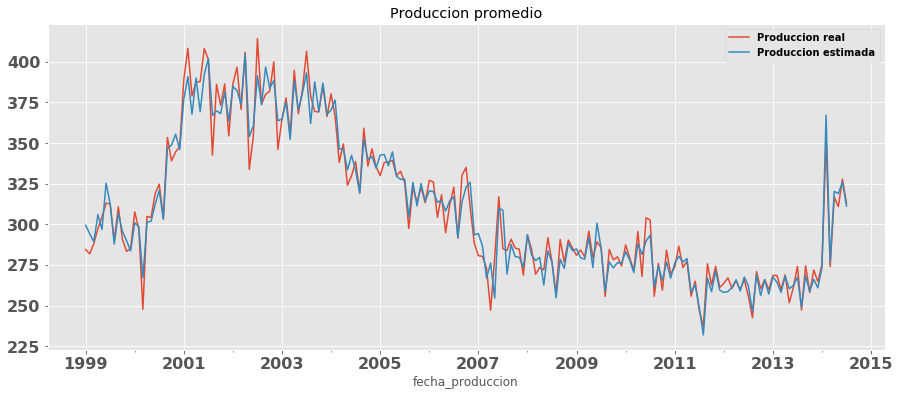

In [518]:
df_train.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean().plot(
    figsize=(15,6), title='Produccion promedio')
plt.legend(['Produccion real', 'Produccion estimada'])

# Pozo Tipo Promedio Base 0
Seleccionar pozos que tengan al menos 10 anios de vida

En promedio tienen 110 mediciones, es decir, al menos 9 anios de vida

In [519]:
 df_train.groupby('Pozo').fecha_produccion.count().median()

109.0

In [520]:
pozos_vivos = df_train.groupby('Pozo').fecha_produccion.count()[df_train.groupby('Pozo').fecha_produccion.count() > 110].index

In [521]:
df_vivos = df_train[df_train.Pozo.isin(pozos_vivos)]

In [522]:
# ax = df_vivos.groupby('fecha_produccion')[['Qomes_b_t','prediction']].mean().plot(
#     figsize=(15,6), title='Produccion promedio en un pozo tipo base 0',linewidth=4.0)

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90),
#                alpha=0.3, color='navy')

# ax.fill_between(sorted(df_vivos.fecha_produccion.unique()), 
#                 df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10),
#                 df_vivos.groupby('fecha_produccion')['prediction'].mean(),
#                alpha=0.3, color='navy')

# plt.legend(['Produccion real', 'Produccion estimada','quantil-90','quantil-10'])

In [523]:
df_vivos2 = df_vivos.groupby('fecha_produccion')[['Produccion_barriles_t','prediction']].mean()
df_vivos2["Qomes_b_t_q90"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.90)
df_vivos2["Qomes_b_t_q10"] = df_vivos.groupby('fecha_produccion')['Produccion_barriles_t'].quantile(0.10)
df_vivos2["prediccion_q90"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.90)
df_vivos2["prediccion_q10"] = df_vivos.groupby('fecha_produccion')['prediction'].quantile(0.10)

In [524]:
# df_vivos2.columns = ['Produccion_promedio', 'prediction', 'prediccion_q90', 'prediccion_q10']

In [525]:
df_vivos2.iplot(title='Perfiles de pozos con su estimacion')

# Generador de serie de tiempo

In [ ]:
# from sklearn.externals import joblib

# # load model
# gbm_pickle = joblib.load('lgb.pkl')

In [ ]:
# clf = gbm_pickle

In [ ]:
num_cols

In [ ]:
num_cols = ['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4', 'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1',
            'diff_t_6_t_5', 'diff_t_5_t_4',
            'diff_t_4_t_3', 'diff_t_3_t_2', 'diff_t_2_t_1', 'std_t_6_t_1', 'mean_t_6_t_1', 
            'median_t_6_t_1', 'min_t_6_t_1', 
            'max_t_6_t_1', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 
            'month_7', 'month_8', 'month_9',
            'month_10', 'month_11', 'month_12', 
            'detenido_mes_antes', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
            'cluster_5', 'latitud', 'longitud']

In [ ]:
df_train.head()

In [ ]:
df_simul = df_train[df_train.Pozo == 'MOLOACAN-836'].reset_index(drop=True)
df_simul.drop(['Qomes_b_t_log','cluster'], 1, inplace=True)
df_simul['y_real'] = df_simul.Qomes_b_t
# se selecciono aleatoriamente

In [ ]:
df_simul.columns

In [ ]:
def gen_cols(df):
    
    df['diff_t_6_t_5'] = df['Qomes_b_t_6'] - df['Qomes_b_t_5']
    df['diff_t_5_t_4'] = df['Qomes_b_t_5'] - df['Qomes_b_t_4']
    df['diff_t_4_t_3'] = df['Qomes_b_t_4'] - df['Qomes_b_t_3']
    df['diff_t_3_t_2'] = df['Qomes_b_t_3'] - df['Qomes_b_t_2']
    df['diff_t_2_t_1'] = df['Qomes_b_t_2'] - df['Qomes_b_t_1']

    df['std_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].std(1)
    df['mean_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].mean(1)
    df['median_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].median(1)
    df['min_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].min(1) 
    df['max_t_6_t_1'] = df[['Qomes_b_t_6', 'Qomes_b_t_5', 'Qomes_b_t_4',
                        'Qomes_b_t_3', 'Qomes_b_t_2', 'Qomes_b_t_1']].max(1)
    return df

In [ ]:
df_simulation = pd.DataFrame(df_simul.iloc[0]).T.reset_index(drop=True)
df_simulation = df_simulation.append(df_simul.iloc[1])
df_simulation.set_value(1,'Qomes_b_t', df_simulation.loc[0,'prediction'])


In [ ]:
gen_cols(df_simulation)

In [ ]:
df_simulation = df_simulation.append(df_simul.iloc[2])
prediccion = clf.predict(df_simul.iloc[1:2][num_cols])[0]
print('estimacion %1.3f' %prediccion)
df_simulation.set_value(2,'Qomes_b_t', prediccion)
df_simulation.set_value(2,'Qomes_b_t_1', df_simulation.loc[1,'Qomes_b_t'])
df_simulation = gen_cols(df_simulation)

In [ ]:
df_simulation

In [ ]:
df_simulation = df_simulation.append(df_simul.iloc[3])
prediccion = clf.predict(df_simul.iloc[2:3][num_cols])[0]
print('estimacion %1.3f' %prediccion)
df_simulation.set_value(3,'Qomes_b_t', prediccion)
df_simulation.set_value(3,'Qomes_b_t_1', df_simulation.loc[2,'Qomes_b_t'])
df_simulation.set_value(3,'Qomes_b_t_2', df_simulation.loc[2,'Qomes_b_t_1'])
df_simulation = gen_cols(df_simulation)

In [ ]:
df_simulation